<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento//BDML_202302/blob/main/Lecture08/Notebook_SS08_ROC.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Missclasification

To work through the steps of probability-based classification, we’ll use a real dataset on loans and credit from a set of local lenders in Germany (taken from the UC Irvine Machine Learning Repository and cleaned for our purposes). 

Credit scoring is a classic problem of classification, and it remains one of the big application domains for ML: use previous loan results (default versus payment) to train a model that can predict the performance of potential new loans.

\begin{align}
Default=f(x) + u
\end{align}

where $Default=I(Default=1)$



In [1]:
#Cargar librerías 
require("pacman")
p_load("tidyverse")


Loading required package: pacman



In [2]:
#Leer los datos 
credit <- readRDS(url("https://github.com/ignaciomsarmiento/datasets/blob/main/credit_class.rds?raw=true"))
#mutacion de factores
credit<-credit %>% mutate(Default=factor(Default,levels=c(1,0),labels=c("Si","No")),
                          history=factor(history,levels=c("good","poor","terrible"),labels=c("buena","mala","terrible")),
                          foreign=factor(foreign,levels=c("foreign","german"),labels=c("extranjero","aleman")),
                          purpose=factor(purpose,levels=c("newcar","usedcar","goods/repair","edu", "biz" ),labels=c("auto_nuevo","auto_usado","bienes","educacion","negocios")))         

head(credit)

,Default,duration,amount,installment,age,history,purpose,foreign,rent
,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,No,6,1169,4,67,terrible,bienes,extranjero,FALSE
2,Si,48,5951,2,22,mala,bienes,extranjero,FALSE
3,No,12,2096,2,49,terrible,educacion,extranjero,FALSE
4,No,42,7882,2,45,mala,bienes,extranjero,FALSE
5,Si,24,4870,3,53,mala,auto_nuevo,extranjero,FALSE
6,No,36,9055,2,35,mala,educacion,extranjero,FALSE


In [3]:
prop.table(table(credit$Default))


 Si  No 
0.3 0.7 

## Preparar la base
### División de la muestra

- El objetivo es predecir bien fuera de muestra

- No queremos sobreajustar a la muestra
  
- Vamos a definir 2 bases

  - Muestra de entrenamiento: vamos a estimar los modelos, buscar parámetros, etc.
  
  -  Muestra de prueba que solo vamos a usar para evaluar los modelos


In [4]:
## First, split the training set 
set.seed(1011)
p_load("caret")

inTrain <- createDataPartition(
  y = credit$Default,## La variable dependiente u objetivo 
  p = .7, ## Usamos 70%  de los datos en el conjunto de entrenamiento 
  list = FALSE)


train <- credit[ inTrain,]
test  <- credit[-inTrain,]

## Accuracy

In [5]:
ctrl<- trainControl(method = "cv",
                    number = 5,
                    classProbs = TRUE,
                    savePredictions = T)


In [6]:
set.seed(123)

class_ranger <- train(
    Default~duration+amount+installment+age+history + purpose+foreign+rent,
    data=train,
    metric = "Accuracy",
    method = "ranger",
    trControl = ctrl,
    tuneGrid=expand.grid(
              mtry = c(1,2,3,4,5,6,7,8),
              splitrule = "gini",
               min.node.size = c(25,50,150,200,250))
)


In [7]:
class_ranger

Random Forest 

700 samples
  8 predictor
  2 classes: 'Si', 'No' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 560, 560, 560, 560, 560 
Resampling results across tuning parameters:

  mtry  min.node.size  Accuracy   Kappa     
  1      25            0.7028571  0.01320755
  1      50            0.7028571  0.01320755
  1     150            0.7000000  0.00000000
  1     200            0.7000000  0.00000000
  1     250            0.7000000  0.00000000
  2      25            0.7057143  0.07176158
  2      50            0.7028571  0.04583215
  2     150            0.7014286  0.01759337
  2     200            0.7000000  0.00733945
  2     250            0.7014286  0.01018519
  3      25            0.6985714  0.09432852
  3      50            0.7014286  0.07369147
  3     150            0.7000000  0.02241561
  3     200            0.7000000  0.01862586
  3     250            0.7028571  0.02042356
  4      25            0.6914286  0.10137211
  4      50    

In [8]:
predictSample <- train   %>% 
    mutate(hat_default = predict(class_ranger, newdata = train, type = "raw")    ## predicted class labels
)  %>% select(Default,hat_default)

head(predictSample)

,Default,hat_default
,<fct>,<fct>
2,Si,Si
3,No,No
4,No,No
5,Si,No
7,No,No
8,No,No


In [9]:
confusionMatrix(data = predictSample$hat_default, reference = predictSample$Default)

Confusion Matrix and Statistics

          Reference
Prediction  Si  No
        Si  86  15
        No 124 475
                                          
               Accuracy : 0.8014          
                 95% CI : (0.7699, 0.8304)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 7.681e-10       
                                          
                  Kappa : 0.4449          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.4095          
            Specificity : 0.9694          
         Pos Pred Value : 0.8515          
         Neg Pred Value : 0.7930          
             Prevalence : 0.3000          
         Detection Rate : 0.1229          
   Detection Prevalence : 0.1443          
      Balanced Accuracy : 0.6895          
                                          
       'Positive' Class : Si              
                              

In [10]:
# Accuracy
mean(predictSample$Default==predictSample$hat_default)

[1] 0.8014286

In [11]:
predictTest <- data.frame(
  Default = test$Default,                                    ## observed class labels
  hat_default = predict(class_ranger, newdata = test, type = "raw")    ## predicted class labels
)


In [12]:
confusionMatrix(data = predictTest$hat_default, reference = predictTest$Default)

Confusion Matrix and Statistics

          Reference
Prediction  Si  No
        Si  22  14
        No  68 196
                                          
               Accuracy : 0.7267          
                 95% CI : (0.6725, 0.7763)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.1726          
                                          
                  Kappa : 0.2146          
                                          
 Mcnemar's Test P-Value : 4.832e-09       
                                          
            Sensitivity : 0.24444         
            Specificity : 0.93333         
         Pos Pred Value : 0.61111         
         Neg Pred Value : 0.74242         
             Prevalence : 0.30000         
         Detection Rate : 0.07333         
   Detection Prevalence : 0.12000         
      Balanced Accuracy : 0.58889         
                                          
       'Positive' Class : Si              
                              

## True Positive Rate


Podemos tratar te maximizar el TPR


\begin{align}
     True\,Positive\,Rate=Sensitivity&=\frac{True \,\,Positives}{Positives} 
  \end{align}
  
  \begin{align}
        Specificity&=\frac{True\,\,Negatives}{Negatives} \nonumber 
  \end{align}
  
\begin{align}
     False\,Positive\,Rate= 1-Specificity&=\frac{False\,\,Positives}{Negatives} \nonumber 
  \end{align}




In [13]:

ctrl2<- trainControl(method = "cv",
                     number = 5,
                     summaryFunction = twoClassSummary,
                     classProbs = TRUE,
                     savePredictions = T)


In [14]:
set.seed(123)

class_ranger_sens <- train(
    Default~duration+amount+installment+age+history + purpose+foreign+rent,
    data=train,
    metric = "Sens",
    method = "ranger",
    trControl = ctrl2,
    tuneGrid=expand.grid(
              mtry = c(1,2,3,4,5,6,7,8),
              splitrule = "gini",
               min.node.size = c(25,50,150,200,250))
)

In [15]:
class_ranger_sens

Random Forest 

700 samples
  8 predictor
  2 classes: 'Si', 'No' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 560, 560, 560, 560, 560 
Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens        Spec     
  1      25            0.6672983  0.00952381  1.0000000
  1      50            0.6706997  0.00952381  1.0000000
  1     150            0.6660836  0.00000000  1.0000000
  1     200            0.6633382  0.00000000  1.0000000
  1     250            0.6629738  0.00000000  1.0000000
  2      25            0.6663751  0.08095238  0.9734694
  2      50            0.6712342  0.05238095  0.9816327
  2     150            0.6700680  0.01904762  0.9938776
  2     200            0.6687075  0.00952381  0.9959184
  2     250            0.6666910  0.00952381  0.9979592
  3      25            0.6595724  0.13333333  0.9408163
  3      50            0.6674441  0.09523810  0.9612245
  3     150            0.6754616  0.02857143  0.9877

In [16]:
predictTest<- test   %>% 
    mutate(hat_default_sens = predict(class_ranger_sens, newdata = test, type = "raw")    ## predicted class labels
)  %>% select(Default,hat_default_sens)


In [17]:
confusionMatrix(data = predictTest$hat_default, reference = predictTest$Default)

Confusion Matrix and Statistics

          Reference
Prediction  Si  No
        Si  24  16
        No  66 194
                                          
               Accuracy : 0.7267          
                 95% CI : (0.6725, 0.7763)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.1726          
                                          
                  Kappa : 0.2264          
                                          
 Mcnemar's Test P-Value : 6.262e-08       
                                          
            Sensitivity : 0.2667          
            Specificity : 0.9238          
         Pos Pred Value : 0.6000          
         Neg Pred Value : 0.7462          
             Prevalence : 0.3000          
         Detection Rate : 0.0800          
   Detection Prevalence : 0.1333          
      Balanced Accuracy : 0.5952          
                                          
       'Positive' Class : Si              
                              


\begin{align}
     True\,Positive\,Rate=Sensitivity&=\frac{True \,\,Positives}{Positives} 
  \end{align}
  
  \begin{align}
        Specificity&=\frac{True\,\,Negatives}{Negatives} \nonumber 
  \end{align}
  
\begin{align}
     False\,Positive\,Rate= 1-Specificity&=\frac{False\,\,Positives}{Negatives} \nonumber 
  \end{align}

## ROC

In [18]:
set.seed(123)

class_ranger_ROC <- train(
    Default~duration+amount+installment+age+history + purpose+foreign+rent,
    data=train,
    metric = "ROC",
     method = "ranger",
    trControl = ctrl2,
    tuneGrid=expand.grid(
              mtry = c(1,2,3,4,5,6,7,8),
              splitrule = "gini",
               min.node.size = c(25,50,150,200,250))
)

In [19]:
class_ranger_ROC

Random Forest 

700 samples
  8 predictor
  2 classes: 'Si', 'No' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 560, 560, 560, 560, 560 
Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens        Spec     
  1      25            0.6672983  0.00952381  1.0000000
  1      50            0.6706997  0.00952381  1.0000000
  1     150            0.6660836  0.00000000  1.0000000
  1     200            0.6633382  0.00000000  1.0000000
  1     250            0.6629738  0.00000000  1.0000000
  2      25            0.6663751  0.08095238  0.9734694
  2      50            0.6712342  0.05238095  0.9816327
  2     150            0.6700680  0.01904762  0.9938776
  2     200            0.6687075  0.00952381  0.9959184
  2     250            0.6666910  0.00952381  0.9979592
  3      25            0.6595724  0.13333333  0.9408163
  3      50            0.6674441  0.09523810  0.9612245
  3     150            0.6754616  0.02857143  0.9877

In [24]:
predictTest <- predictTest  %>% 
    mutate(class_ROC = predict(class_ranger_ROC, newdata = test, type = "raw"), # predicted class labels
           p_hat_ROC=predict(class_ranger_ROC, newdata = test, type = "prob")$Si,         ## predicted class probabilities#
           Default_num=ifelse(Default=="No",0,1)
)

head(predictTest,100)

,Default,hat_default_sens,class_ROC,p_hat_ROC,Default_num
,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,No,No,No,0.1282233,0
6,No,No,No,0.4391797,0
9,No,No,No,0.2599928,0
11,Si,No,No,0.3441231,1
13,No,No,No,0.3351296,0
17,No,No,No,0.1545768,0
22,No,No,No,0.1593205,0
24,No,No,No,0.1385457,0
25,No,No,No,0.1471724,0


In [21]:
confusionMatrix(data = predictTest$class_ROC, reference = predictTest$Default)

Confusion Matrix and Statistics

          Reference
Prediction  Si  No
        Si   8   2
        No  82 208
                                          
               Accuracy : 0.72            
                 95% CI : (0.6655, 0.7701)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.2456          
                                          
                  Kappa : 0.1064          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.08889         
            Specificity : 0.99048         
         Pos Pred Value : 0.80000         
         Neg Pred Value : 0.71724         
             Prevalence : 0.30000         
         Detection Rate : 0.02667         
   Detection Prevalence : 0.03333         
      Balanced Accuracy : 0.53968         
                                          
       'Positive' Class : Si              
                              

In [25]:
p_load("pROC")
rfROC <- roc(predictTest$Default, predictTest$p_hat_ROC, levels = rev(levels(predictTest$Default)))
rfROC

Setting direction: controls < cases




Call:
roc.default(response = predictTest$Default, predictor = predictTest$p_hat_ROC,     levels = rev(levels(predictTest$Default)))

Data: predictTest$p_hat_ROC in 210 controls (predictTest$Default No) < 90 cases (predictTest$Default Si).
Area under the curve: 0.7524

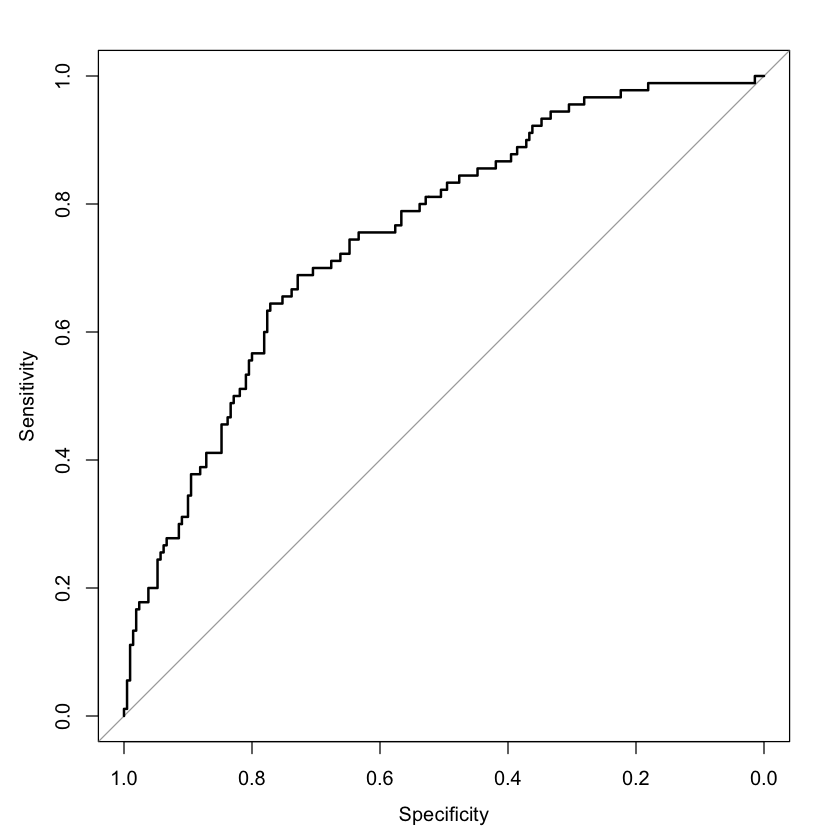

In [26]:
plot(rfROC)

In [27]:
FPR<-mean(predictTest$class_ROC[predictTest$Default=="No"]=="No")
TPR<-mean(predictTest$class_ROC[predictTest$Default=="Si"]=="Si")

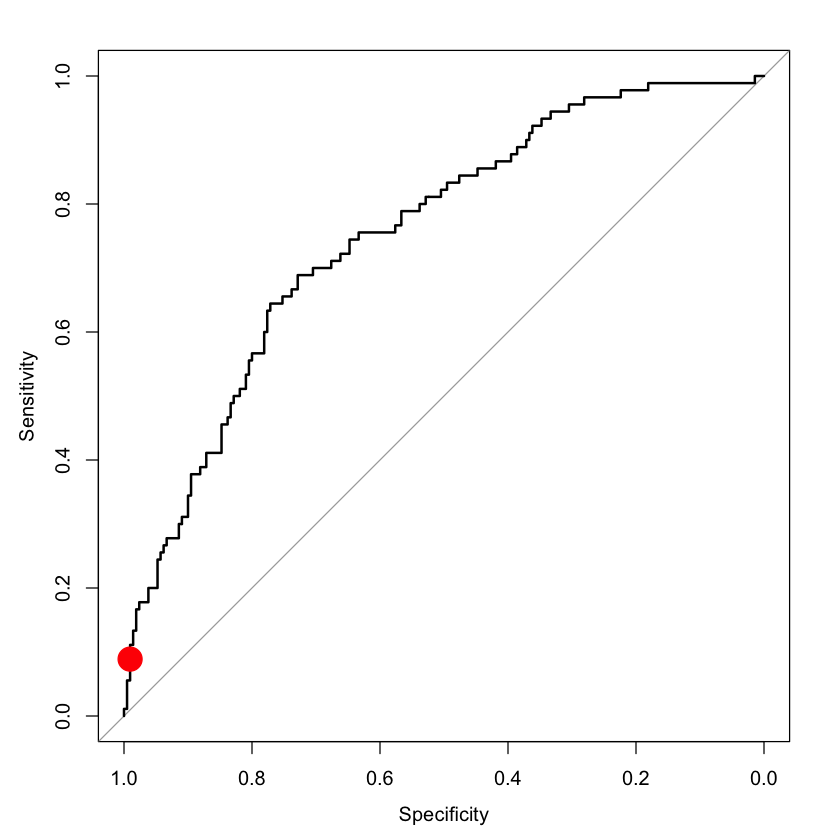

In [28]:
plot(rfROC)
points(x= FPR, 
       y=TPR, 
       cex=4, pch=20, col='red') 

In [29]:
predictTest <- predictTest  %>% 
    mutate(class_ROC_2 = factor(ifelse(p_hat_ROC>.2,"Si","No"),levels=c("Si","No"))
)

In [30]:
confusionMatrix(data = predictTest$class_ROC_2, reference = predictTest$Default)

Confusion Matrix and Statistics

          Reference
Prediction  Si  No
        Si  85 141
        No   5  69
                                          
               Accuracy : 0.5133          
                 95% CI : (0.4552, 0.5712)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1907          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9444          
            Specificity : 0.3286          
         Pos Pred Value : 0.3761          
         Neg Pred Value : 0.9324          
             Prevalence : 0.3000          
         Detection Rate : 0.2833          
   Detection Prevalence : 0.7533          
      Balanced Accuracy : 0.6365          
                                          
       'Positive' Class : Si              
                              

In [31]:
FPR_2<-mean(predictTest$class_ROC_2[predictTest$Default=="No"]=="No")
TPR_2<-mean(predictTest$class_ROC_2[predictTest$Default=="Si"]=="Si")


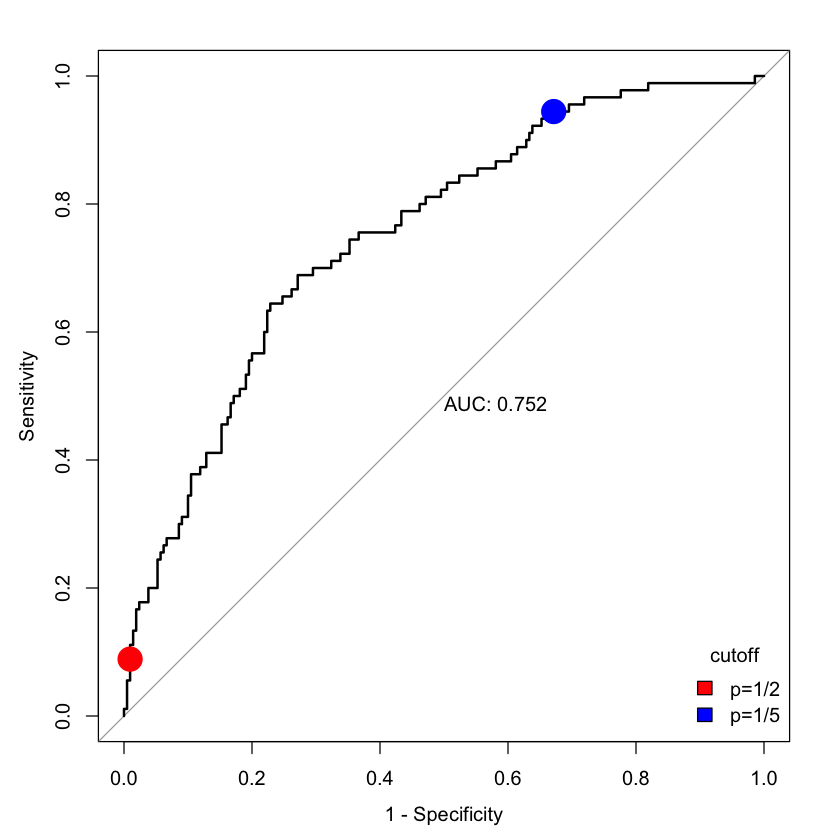

In [32]:
plot(rfROC, print.auc=TRUE,legacy.axes=TRUE)
## our .5 rule cutoff
points(x= FPR, 
       y=TPR, 
       cex=4, pch=20, col='red') 
## A .2 rule cutoff
points(x= FPR_2, 
       y=TPR_2, 
       cex=4, pch=20, col='blue') 
legend("bottomright",fill=c("red","blue"), legend=c("p=1/2","p=1/5"),bty="n",title="cutoff")

### Closest to top left cutoff

Otro enfoque es encontrar el punto en la curva ROC que está más cerca (es decir, la distancia más corta) al modelo perfecto (con 100\% de sensibilidad y 100\% de especificidad), que está asociado con la esquina superior izquierda de la gráfica.

In [33]:
rfThresh <- coords(rfROC, x = "best", best.method = "closest.topleft")
rfThresh

threshold,specificity,sensitivity
<dbl>,<dbl>,<dbl>
0.3280265,0.7285714,0.6888889


In [34]:
predictTest <- predictTest  %>% 
    mutate(class_ROC_Thresh = factor(ifelse(p_hat_ROC>rfThresh$threshold,"Si","No"),levels=c("Si","No"))
)

In [35]:
confusionMatrix(data = predictTest$class_ROC_Thresh, reference = predictTest$Default)

Confusion Matrix and Statistics

          Reference
Prediction  Si  No
        Si  62  57
        No  28 153
                                        
               Accuracy : 0.7167        
                 95% CI : (0.662, 0.767)
    No Information Rate : 0.7           
    P-Value [Acc > NIR] : 0.287360      
                                        
                  Kappa : 0.3823        
                                        
 Mcnemar's Test P-Value : 0.002389      
                                        
            Sensitivity : 0.6889        
            Specificity : 0.7286        
         Pos Pred Value : 0.5210        
         Neg Pred Value : 0.8453        
             Prevalence : 0.3000        
         Detection Rate : 0.2067        
   Detection Prevalence : 0.3967        
      Balanced Accuracy : 0.7087        
                                        
       'Positive' Class : Si            
                                        

In [36]:
FPR_3<-mean(predictTest$class_ROC_Thresh[predictTest$Default=="No"]=="No")
TPR_3<-mean(predictTest$class_ROC_Thresh[predictTest$Default=="Si"]=="Si")


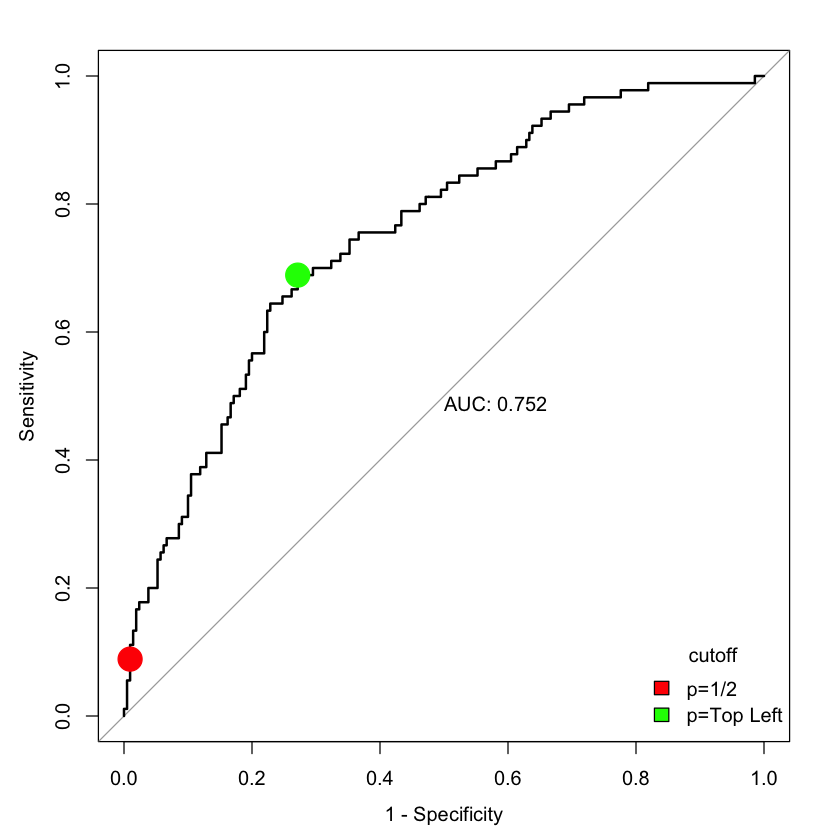

In [37]:
plot(rfROC, print.auc=TRUE,legacy.axes=TRUE)
## our .5 rule cutoff
points(x= FPR, 
       y=TPR, 
       cex=4, pch=20, col='red') 
## A optimal threshold
points(x= FPR_3, 
       y=TPR_3, 
       cex=4, pch=20, col='green') 
legend("bottomright",fill=c("red","green"), legend=c("p=1/2","p=Top Left"),bty="n",title="cutoff")